In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Make plots show inside the notebook
%matplotlib inline



In [35]:
# Read CSV files from data folder
sales = pd.read_csv("data/kiwo.csv")
weather = pd.read_csv("data/wetter.csv")
umsatz = pd.read_csv("data/umsatzdaten_gekuerzt.csv")

# Quick check
sales.head(), weather.head(), umsatz.head()


(        Datum  KielerWoche
 0  2012-06-16            1
 1  2012-06-17            1
 2  2012-06-18            1
 3  2012-06-19            1
 4  2012-06-20            1,
         Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
 0  2012-01-01         8.0      9.8250                   14        58.0
 1  2012-01-02         7.0      7.4375                   12         NaN
 2  2012-01-03         8.0      5.5375                   18        63.0
 3  2012-01-04         4.0      5.6875                   19        80.0
 4  2012-01-05         6.0      5.3000                   23        80.0,
         Datum  Warengruppe      Umsatz
 0  2013-07-01            1  148.828353
 1  2013-07-02            1  159.793757
 2  2013-07-03            1  111.885594
 3  2013-07-04            1  168.864941
 4  2013-07-05            1  171.280754)

In [20]:
# Convert date columns to datetime
sales["Datum"] = pd.to_datetime(sales["Datum"])
weather["Datum"] = pd.to_datetime(weather["Datum"])
umsatz["Datum"] = pd.to_datetime(umsatz["Datum"])


In [38]:
# Merge sales and weather by date
sales_weather = pd.merge(
    sales,
    weather,
    on="Datum",
    how="inner"  # only dates that exist in both tables
)

sales_weather.head()


,Datum,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode
0,2012-06-16,1,6.0,18.4625,10,25.0
1,2012-06-17,1,6.0,16.9625,14,25.0
2,2012-06-18,1,6.0,19.5875,19,95.0
3,2012-06-19,1,6.0,17.3125,6,NaN
4,2012-06-20,1,6.0,17.6500,12,NaN


In [22]:
# Merge the third table (umsatz) as well
full_data = pd.merge(
    sales_weather,
    umsatz,
    on="Datum",
    how="left"  # keep all rows from sales_weather
)

full_data.head()


,Datum,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Warengruppe,Umsatz
0,2012-06-16,1,6.0,18.4625,10,25.0,NaN,NaN
1,2012-06-17,1,6.0,16.9625,14,25.0,NaN,NaN
2,2012-06-18,1,6.0,19.5875,19,95.0,NaN,NaN
3,2012-06-19,1,6.0,17.3125,6,NaN,NaN,NaN
4,2012-06-20,1,6.0,17.6500,12,NaN,NaN,NaN


In [23]:
# Check basic info
full_data.info()

# Descriptive statistics for numeric columns
full_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                250 non-null    datetime64[ns]
 1   KielerWoche          250 non-null    int64         
 2   Bewoelkung           250 non-null    float64       
 3   Temperatur           250 non-null    float64       
 4   Windgeschwindigkeit  250 non-null    int64         
 5   Wettercode           184 non-null    float64       
 6   Warengruppe          223 non-null    float64       
 7   Umsatz               223 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 15.8 KB


,Datum,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Warengruppe,Umsatz
count,250,250.0,250.000000,250.000000,250.000000,184.000000,223.000000,223.000000
mean,2016-05-02 01:09:07.200000,1.0,4.920000,18.413450,11.596000,47.630435,2.991031,260.559219
min,2012-06-16 00:00:00,1.0,0.000000,11.562500,5.000000,0.000000,1.000000,46.452105
25%,2014-09-26 00:00:00,1.0,4.000000,16.303125,8.000000,21.000000,2.000000,127.937248
50%,2016-06-21 00:00:00,1.0,5.000000,18.000000,10.000000,61.000000,3.000000,213.304835
75%,2017-06-24 00:00:00,1.0,7.000000,20.125000,14.000000,61.000000,4.000000,368.270772
max,2019-06-30 00:00:00,1.0,8.000000,28.775000,20.000000,95.000000,5.000000,861.858617
std,NaN,0.0,2.107931,3.377975,3.946528,30.492395,1.420541,177.014984


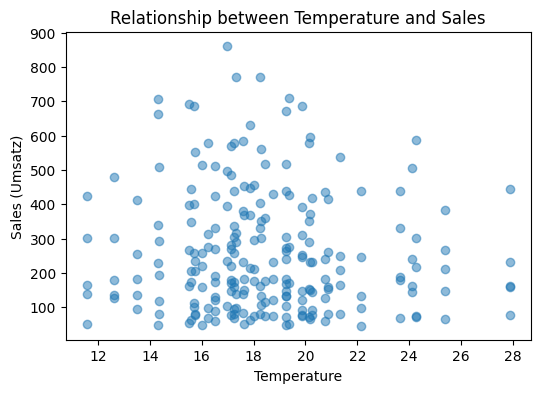

In [24]:
# Scatter plot: Temperature vs Sales
plt.figure(figsize=(6,4))
plt.scatter(full_data["Temperatur"], full_data["Umsatz"], alpha=0.5)
plt.xlabel("Temperature")
plt.ylabel("Sales (Umsatz)")
plt.title("Relationship between Temperature and Sales")
plt.show()


In [25]:
#descriptive stats
# Show basic DataFrame info
sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datum        72 non-null     datetime64[ns]
 1   KielerWoche  72 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [26]:
sales.describe()


,Datum,KielerWoche
count,72,72.0
mean,2015-12-23 00:00:00,1.0
min,2012-06-16 00:00:00,1.0
25%,2014-03-24 00:00:00,1.0
50%,2015-12-23 00:00:00,1.0
75%,2017-09-22 00:00:00,1.0
max,2019-06-30 00:00:00,1.0
std,NaN,0.0


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load datasets
sales = pd.read_csv("data/kiwo.csv")
weather = pd.read_csv("data/wetter.csv")
umsatz = pd.read_csv("data/umsatzdaten_gekuerzt.csv")


In [28]:
#Descriptive statistics — Sales (kiwo.csv)
print("=== Sales Dataset Info ===")
sales.info()
print("\n=== Sales Dataset Describe ===")
display(sales.describe(include='all'))


=== Sales Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Datum        72 non-null     object
 1   KielerWoche  72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB

=== Sales Dataset Describe ===


,Datum,KielerWoche
count,72,72.0
unique,72,NaN
top,2012-06-16,NaN
freq,1,NaN
mean,NaN,1.0
std,NaN,0.0
min,NaN,1.0
25%,NaN,1.0
50%,NaN,1.0
75%,NaN,1.0


In [29]:
#Descriptive statistics — Weather (wetter.csv)
print("=== Weather Dataset Info ===")
weather.info()
print("\n=== Weather Dataset Describe ===")
display(weather.describe(include='all'))


=== Weather Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                2601 non-null   object 
 1   Bewoelkung           2591 non-null   float64
 2   Temperatur           2601 non-null   float64
 3   Windgeschwindigkeit  2601 non-null   int64  
 4   Wettercode           1932 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 101.7+ KB

=== Weather Dataset Describe ===


,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode
count,2601,2591.000000,2601.000000,2601.000000,1932.000000
unique,2601,NaN,NaN,NaN,NaN
top,2012-01-01,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,4.805866,12.099586,11.191080,37.484472
std,NaN,2.578299,7.174357,4.124693,27.567144
min,NaN,0.000000,-10.250000,3.000000,0.000000
25%,NaN,3.000000,6.512500,8.000000,10.000000
50%,NaN,6.000000,12.000000,10.000000,28.000000
75%,NaN,7.000000,17.825000,14.000000,61.000000


In [30]:
#Descriptive statistics — Umsatz (umsatzdaten_gekürzt.csv)
print("=== Umsatz Dataset Info ===")
umsatz.info()
print("\n=== Umsatz Dataset Describe ===")
display(umsatz.describe(include='all'))


=== Umsatz Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10899 entries, 0 to 10898
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datum        10899 non-null  object 
 1   Warengruppe  10899 non-null  int64  
 2   Umsatz       10899 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 255.6+ KB

=== Umsatz Dataset Describe ===


,Datum,Warengruppe,Umsatz
count,10899,10899.000000,10899.000000
unique,2121,NaN,NaN
top,2018-12-16,NaN,NaN
freq,6,NaN,NaN
mean,NaN,3.090834,206.663010
std,NaN,1.490105,142.811267
min,NaN,1.000000,7.051201
25%,NaN,2.000000,97.532597
50%,NaN,3.000000,163.299762
75%,NaN,4.000000,280.813505


In [41]:
full_data.isnull().sum()


Datum                   0
KielerWoche             0
Bewoelkung              0
Temperatur              0
Windgeschwindigkeit     0
Wettercode             66
Warengruppe            27
Umsatz                 27
dtype: int64

In [ ]:
#summary_stats_after_dataJoin
full_data.describe(include="all")


,Datum,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,Warengruppe,Umsatz
count,250,250.0,250.000000,250.000000,250.000000,184.000000,223.000000,223.000000
mean,2016-05-02 01:09:07.200000,1.0,4.920000,18.413450,11.596000,47.630435,2.991031,260.559219
min,2012-06-16 00:00:00,1.0,0.000000,11.562500,5.000000,0.000000,1.000000,46.452105
25%,2014-09-26 00:00:00,1.0,4.000000,16.303125,8.000000,21.000000,2.000000,127.937248
50%,2016-06-21 00:00:00,1.0,5.000000,18.000000,10.000000,61.000000,3.000000,213.304835
75%,2017-06-24 00:00:00,1.0,7.000000,20.125000,14.000000,61.000000,4.000000,368.270772
max,2019-06-30 00:00:00,1.0,8.000000,28.775000,20.000000,95.000000,5.000000,861.858617
std,NaN,0.0,2.107931,3.377975,3.946528,30.492395,1.420541,177.014984
